Team Project Checkpoint 1
David Geis
Abhijeet Gupta
Noralene Marcum
Meadow Motz
Shruti Singh
Patrick Thomas

Note: archive.zip should be unzipped in the same folder as this notebook. 

In [7]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern, hog
from sklearn.decomposition import PCA
import pickle
import joblib
import os
import faiss
from tqdm import tqdm

def preprocess_images(input_dir, output_dir, size=(300, 300)):
    image_paths = collect_image_paths(input_dir)
    relPathLoc = len(input_dir)
    for file in image_paths:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            relPath = file[relPathLoc:]
            new_path = output_dir + relPath
            img = cv2.imread(file)
            if img is not None:
                img_resized = cv2.resize(img, size)
                result = cv2.imwrite(new_path, img_resized)
                if (result == False):
                    os.makedirs(os.path.dirname(new_path), exist_ok=True)
                    result = cv2.imwrite(new_path, img_resized)

# Resize image to ensure consistency
def resize_image(image, size=(300, 300)):
    return cv2.resize(image, size)

# Extract Local Binary Patterns (LBP) features
def extract_lbp_features(image, P=8, R=1, method='uniform'):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P, R, method)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

# Extract Color Histogram features
def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# Extract SIFT features
def extract_sift_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is not None:
        return np.mean(descriptors, axis=0)
    else:
        return np.zeros(128)

# Extract Histogram of Oriented Gradients (HOG) features
def extract_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_feat, _ = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
    return hog_feat

# Collect all image paths recursively
def collect_image_paths(image_dir):
    image_paths = []
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Main execution
if __name__ == '__main__':
    output_directory = 'preprocessed_images'
    input_directory = 'archive/training'
    print("Preprocessing images...")
    preprocess_images(input_directory, output_directory)

    # Extract all features and combine
    feature_db = {}
    all_features = []
    image_ids = []

    print("Extracting features from images...")
    image_paths = collect_image_paths(output_directory)
    idx = 0
    for file in image_paths:
        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
            img_resized = cv2.imread(file)

            sift_feat = extract_sift_features(img_resized)
            hog_feat = extract_hog_features(img_resized)
            lbp_feat = extract_lbp_features(img_resized)
            color_hist_feat = extract_color_histogram(img_resized)
            
            # Handle varying feature lengths
            features = []
            features.extend(sift_feat)
            features.extend(hog_feat)
            features.extend(lbp_feat)
            features.extend(color_hist_feat)
            
            combined_feat = np.array(features)
            feature_db[idx] = file
            all_features.append(combined_feat)
            image_ids.append(idx)
        idx = idx + 1

    # Convert to numpy array
    all_features = np.array(all_features)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=300)  # Adjust n_components as needed
    reduced_features = pca.fit_transform(all_features)

    print("Creating FAISS index...")
    dimension = reduced_features.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(reduced_features)
    faiss.write_index(index, 'food_faiss.index')

    # Save meta storage (image ID to path mapping)
    with open('meta_storage.pkl', 'wb') as f:
        pickle.dump(feature_db, f)

    # Save PCA model for future use
    joblib.dump(pca, 'pca_model.pkl')

    print("Feature extraction with all methods and indexing completed successfully.")

Preprocessing images...
Extracting features from images...
Creating FAISS index...
Feature extraction with all methods and indexing completed successfully.


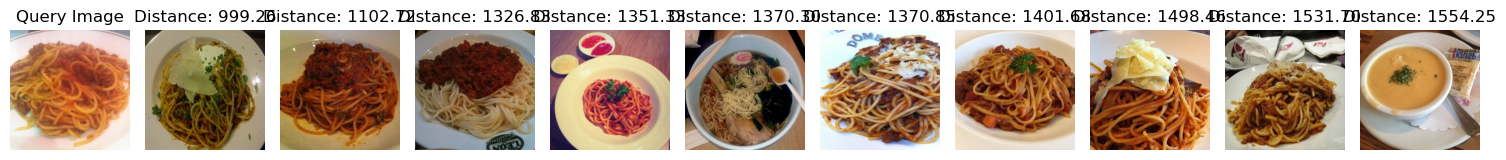

Top similar images:
Image: preprocessed_images\Noodles-Pasta\193.jpg, Similarity Distance: 999.2550048828125
Image: preprocessed_images\Noodles-Pasta\90.jpg, Similarity Distance: 1102.7181396484375
Image: preprocessed_images\Noodles-Pasta\197.jpg, Similarity Distance: 1326.8333740234375
Image: preprocessed_images\Noodles-Pasta\53.jpg, Similarity Distance: 1351.3294677734375
Image: preprocessed_images\Noodles-Pasta\61.jpg, Similarity Distance: 1370.299072265625
Image: preprocessed_images\Noodles-Pasta\342.jpg, Similarity Distance: 1370.8466796875
Image: preprocessed_images\Noodles-Pasta\259.jpg, Similarity Distance: 1401.6822509765625
Image: preprocessed_images\Noodles-Pasta\100.jpg, Similarity Distance: 1498.4556884765625
Image: preprocessed_images\Noodles-Pasta\274.jpg, Similarity Distance: 1531.7037353515625
Image: preprocessed_images\Soup\548.jpg, Similarity Distance: 1554.249755859375


In [13]:
import cv2
import numpy as np
import faiss
import joblib
from skimage.feature import local_binary_pattern, hog
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Resize image to ensure consistency
def resize_image(image, size=(300, 300)):
    return cv2.resize(image, size)

# Extract Local Binary Patterns (LBP) features
def extract_lbp_features(image, P=8, R=1, method='uniform'):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P, R, method)
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    return hist

# Extract Color Histogram features
def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

# Extract SIFT features
def extract_sift_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    if descriptors is not None:
        return np.mean(descriptors, axis=0)
    else:
        return np.zeros(128)

# Extract Histogram of Oriented Gradients (HOG) features
def extract_hog_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hog_feat, _ = hog(gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
    return hog_feat

# Extract PCA features (requires a trained PCA model)
def extract_pca_features(image, pca_model):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature_vector = gray.flatten()
    reduced_features = pca_model.transform([feature_vector])
    return reduced_features.flatten()

# Resize image to ensure consistency
def resize_image(image, size=(300, 300)):
    return cv2.resize(image, size)

# Function to search similar images
def search_similar_images(query_image_path, index, pca, meta, top_k=10):
    img = cv2.imread(query_image_path)
    img_resized = resize_image(img)

    sift_feat = extract_sift_features(img_resized)
    hog_feat = extract_hog_features(img_resized)
    lbp_feat = extract_lbp_features(img_resized)
    color_hist_feat = extract_color_histogram(img_resized)

    # Handle varying feature lengths
    features = []
    features.extend(sift_feat)
    features.extend(hog_feat)
    features.extend(lbp_feat)
    features.extend(color_hist_feat)
    
    combined_feat = np.array(features).reshape(1, -1)
    
    # Apply PCA transformation
    reduced_feat = pca.transform(combined_feat)
    reduced_feat = np.array(reduced_feat).astype('float32')
    
    # Search in FAISS index
    distances, indices = index.search(reduced_feat, top_k)
    
    # Retrieve similar image paths
    similar_images = [(meta[idx], distances[0][i]) for i, idx in enumerate(indices[0])]
    return similar_images

# Visualization of results
def visualize_results(query_image_path, similar_images):
    plt.figure(figsize=(15, 5))

    # Display query image
    query_img = cv2.cvtColor(cv2.imread(query_image_path), cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(similar_images) + 1, 1)
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis('off')

    # Display similar images
    for i, (img_path, distance) in enumerate(similar_images):
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(similar_images) + 1, i + 2)
        plt.imshow(img)
        plt.title(f"Distance: {distance:.2f}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Load your FAISS index, PCA model, and image IDs
faiss_index = faiss.read_index('food_faiss.index')
pca_model = joblib.load('pca_model.pkl')
image_ids = joblib.load('meta_storage.pkl')

# Run example
#query_image = 'archive/validation/Vegetable-Fruit/11.jpg'
query_image = 'archive/validation/Noodles-Pasta/0.jpg'

similar_images = search_similar_images(query_image, faiss_index, pca_model, image_ids)

visualize_results(query_image, similar_images)

print("Top similar images:")
for path, distance in similar_images:
    print(f"Image: {path}, Similarity Distance: {distance}")